# Introduction

In this guided project, we're going to learn how to:

- Import data into SQLite
 - Design a normalized database schema
 - Create tables for our schema
 - Insert data into our schema
 
 

## The Data

We will be working with a file of [Major League Baseball games](https://en.wikipedia.org/wiki/Major_League_Baseball) from [Retrosheet](. Retrosheet compiles detailed statistics on baseball games from the 1800s through to today. The main file we will be working from `game_log.csv`, has been produced by combining 127 separate CSV files from retrosheet, and has been pre-cleaned to remove some inconsistencies. The game log has hundreds of data points on each game which we will normalize into several separate tables using SQL, providing a robust database of game-level statistics.

In addition to the main file, we have also included three 'helper' files, also sourced from Retrosheet:

 - `park_codes.csv`
 - `person_codes.csv`
 - `team_codes.csv`

These three helper files in some cases contain extra data, but will also make things easier as they will form the basis for three of our normalized tables.

An important first step when working with any new data is to perform exploratory data analysis (EDA). EDA gets us familiar with the data and gives us a level of background knowledge that will help us throughout our project. The methods you use when performing EDA will depend on what you plan to do with the data. In our case, we're wanting to create a normalized database, so our focus should be:

 - Becoming familiar, at a high level, with the meaning of each column in each file.
 - Thinking about the relationships between columns within each file.
 - Thinking about the relationships between columns across different files.

We'll import the needed modules next, and get started exploring the data by using pandas.

In [4]:
import sqlite3
import pandas as pd
import csv

# prevent the DataFrame output from being truncated
pd.set_option('max_columns', 180)
pd.set_option('max_rows', 200000)
pd.set_option('max_colwidth', 5000)

In [42]:
#uncomment next line to delete the database file and start over
#!rm mlb.db # on unix
#!del /F mlb.db # on windows

In [5]:
log = pd.read_csv("game_log.csv",low_memory=False)
print(log.shape)
log.head()

(171907, 161)


,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,h_score,length_outs,day_night,completion,forefeit,protest,park_id,attendance,length_minutes,v_line_score,h_line_score,v_at_bats,v_hits,v_doubles,v_triples,v_homeruns,v_rbi,v_sacrifice_hits,v_sacrifice_flies,v_hit_by_pitch,v_walks,v_intentional_walks,v_strikeouts,v_stolen_bases,v_caught_stealing,v_grounded_into_double,v_first_catcher_interference,v_left_on_base,v_pitchers_used,v_individual_earned_runs,v_team_earned_runs,v_wild_pitches,v_balks,v_putouts,v_assists,v_errors,v_passed_balls,v_double_plays,v_triple_plays,h_at_bats,h_hits,h_doubles,h_triples,h_homeruns,h_rbi,h_sacrifice_hits,h_sacrifice_flies,h_hit_by_pitch,h_walks,h_intentional_walks,h_strikeouts,h_stolen_bases,h_caught_stealing,h_grounded_into_double,h_first_catcher_interference,h_left_on_base,h_pitchers_used,h_individual_earned_runs,h_team_earned_runs,h_wild_pitches,h_balks,h_putouts,h_assists,h_errors,h_passed_balls,h_double_plays,h_triple_plays,hp_umpire_id,hp_umpire_name,1b_umpire_id,1b_umpire_name,2b_umpire_id,2b_umpire_name,3b_umpire_id,3b_umpire_name,lf_umpire_id,lf_umpire_name,rf_umpire_id,rf_umpire_name,v_manager_id,v_manager_name,h_manager_id,h_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_rbi_batter_id,winning_rbi_batter_id_name,v_starting_pitcher_id,v_starting_pitcher_name,h_starting_pitcher_id,h_starting_pitcher_name,v_player_1_id,v_player_1_name,v_player_1_def_pos,v_player_2_id,v_player_2_name,v_player_2_def_pos,v_player_3_id,v_player_3_name,v_player_3_def_pos,v_player_4_id,v_player_4_name,v_player_4_def_pos,v_player_5_id,v_player_5_name,v_player_5_def_pos,v_player_6_id,v_player_6_name,v_player_6_def_pos,v_player_7_id,v_player_7_name,v_player_7_def_pos,v_player_8_id,v_player_8_name,v_player_8_def_pos,v_player_9_id,v_player_9_name,v_player_9_def_pos,h_player_1_id,h_player_1_name,h_player_1_def_pos,h_player_2_id,h_player_2_name,h_player_2_def_pos,h_player_3_id,h_player_3_name,h_player_3_def_pos,h_player_4_id,h_player_4_name,h_player_4_def_pos,h_player_5_id,h_player_5_name,h_player_5_def_pos,h_player_6_id,h_player_6_name,h_player_6_def_pos,h_player_7_id,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,NaN,1,FW1,NaN,1,0,2,54.0,D,NaN,NaN,NaN,FOR01,200.0,120.0,000000000,010010000,30.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,6.0,1.0,NaN,-1.0,NaN,4.0,1.0,1.0,1.0,0.0,0.0,27.0,9.0,0.0,3.0,0.0,0.0,31.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN,-1.0,NaN,3.0,1.0,0.0,0.0,0.0,0.0,27.0,3.0,3.0,1.0,1.0,0.0,boakj901,John Boake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,paboc101,Charlie Pabor,lennb101,Bill Lennon,mathb101,Bobby Mathews,prata101,Al Pratt,NaN,NaN,NaN,NaN,prata101,Al Pratt,mathb101,Bobby Mathews,whitd102,Deacon White,2.0,kimbg101,Gene Kimball,4.0,paboc101,Charlie Pabor,7.0,allia101,Art Allison,8.0,white104,Elmer White,9.0,prata101,Al Pratt,1.0,sutte101,Ezra Sutton,5.0,carlj102,Jim Carleton,3.0,bassj101,John Bass,6.0,selmf101,Frank Sellman,5.0,mathb101,Bobby Mathews,1.0,foraj101,Jim Foran,3.0,goldw101,Wally Goldsmith,6.0,lennb101,Bill Lennon,2.0,caret101,Tom Carey,4.0,mince101,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,NaN,1,WS3,NaN,1,20,18,54.0,D,NaN,NaN,NaN,WAS01,5000.0,145.0,107000435,640113030,41.0,13.0,1.0,2.0,0.0,13.0,0.0,0.0,0.0,18.0,NaN,5.0,3.0,NaN,-1.0,NaN,12.0,1.0,6.0,6.0,1.0,0.0,27.0,13.0,10.0,1.0,2.0,0.0,49.0,14.0,2.0,0.0,0.0,11.0,0.0,0.0,0.0,10.0,NaN,2.0,1.0,NaN,-1.0,NaN,14.0,1.0,7.0,7.0,0.0,0.0,27.0,20.0,10.0,2.0,3.0,0.0,dobsh901,Henry Dobson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wrigh101,Harry Wright,younn801,Nick Young,spala101,Al Spalding,braia102,Asa Brainard,NaN,NaN,NaN,NaN,spala101,Al Spalding,braia102,Asa Brainard,wrigg101,George Wright,6.0,barnr102,Ross

In [6]:
log.tail()

,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,h_score,length_outs,day_night,completion,forefeit,protest,park_id,attendance,length_minutes,v_line_score,h_line_score,v_at_bats,v_hits,v_doubles,v_triples,v_homeruns,v_rbi,v_sacrifice_hits,v_sacrifice_flies,v_hit_by_pitch,v_walks,v_intentional_walks,v_strikeouts,v_stolen_bases,v_caught_stealing,v_grounded_into_double,v_first_catcher_interference,v_left_on_base,v_pitchers_used,v_individual_earned_runs,v_team_earned_runs,v_wild_pitches,v_balks,v_putouts,v_assists,v_errors,v_passed_balls,v_double_plays,v_triple_plays,h_at_bats,h_hits,h_doubles,h_triples,h_homeruns,h_rbi,h_sacrifice_hits,h_sacrifice_flies,h_hit_by_pitch,h_walks,h_intentional_walks,h_strikeouts,h_stolen_bases,h_caught_stealing,h_grounded_into_double,h_first_catcher_interference,h_left_on_base,h_pitchers_used,h_individual_earned_runs,h_team_earned_runs,h_wild_pitches,h_balks,h_putouts,h_assists,h_errors,h_passed_balls,h_double_plays,h_triple_plays,hp_umpire_id,hp_umpire_name,1b_umpire_id,1b_umpire_name,2b_umpire_id,2b_umpire_name,3b_umpire_id,3b_umpire_name,lf_umpire_id,lf_umpire_name,rf_umpire_id,rf_umpire_name,v_manager_id,v_manager_name,h_manager_id,h_manager_name,winning_pitcher_id,winning_pitcher_name,losing_pitcher_id,losing_pitcher_name,saving_pitcher_id,saving_pitcher_name,winning_rbi_batter_id,winning_rbi_batter_id_name,v_starting_pitcher_id,v_starting_pitcher_name,h_starting_pitcher_id,h_starting_pitcher_name,v_player_1_id,v_player_1_name,v_player_1_def_pos,v_player_2_id,v_player_2_name,v_player_2_def_pos,v_player_3_id,v_player_3_name,v_player_3_def_pos,v_player_4_id,v_player_4_name,v_player_4_def_pos,v_player_5_id,v_player_5_name,v_player_5_def_pos,v_player_6_id,v_player_6_name,v_player_6_def_pos,v_player_7_id,v_player_7_name,v_player_7_def_pos,v_player_8_id,v_player_8_name,v_player_8_def_pos,v_player_9_id,v_player_9_name,v_player_9_def_pos,h_player_1_id,h_player_1_name,h_player_1_def_pos,h_player_2_id,h_player_2_name,h_player_2_def_pos,h_player_3_id,h_player_3_name,h_player_3_def_pos,h_player_4_id,h_player_4_name,h_player_4_def_pos,h_player_5_id,h_player_5_name,h_player_5_def_pos,h_player_6_id,h_player_6_name,h_player_6_def_pos,h_player_7_id,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
171902,20161002,0,Sun,MIL,NL,162,COL,NL,162,6,4,60.0,D,NaN,NaN,NaN,DEN02,27762.0,203.0,0200000202,1100100010,39.0,10.0,4.0,1.0,2.0,6.0,0.0,0.0,1.0,4.0,0.0,12.0,2.0,1.0,0.0,0.0,8.0,7.0,4.0,4.0,1.0,0.0,30.0,12.0,1.0,0.0,0.0,0.0,41.0,13.0,4.0,0.0,1.0,4.0,1.0,0.0,1.0,3.0,0.0,11.0,0.0,1.0,0.0,0.0,12.0,5.0,6.0,6.0,0.0,0.0,30.0,13.0,0.0,0.0,0.0,0.0,barrs901,Scott Barry,woodt901,Tom Woodring,randt901,Tony Randazzo,ortir901,Roberto Ortiz,NaN,NaN,NaN,NaN,counc001,Craig Counsell,weisw001,Walt Weiss,thort001,Tyler Thornburg,rusic001,Chris Rusin,knebc001,Corey Knebel,susaa001,Andrew Susac,cravt001,Tyler Cravy,marqg001,German Marquez,villj001,Jonathan Villar,5.0,genns001,Scooter Gennett,4.0,cartc002,Chris Carter,3.0,santd002,Domingo Santana,9.0,pereh001,Hernan Perez,8.0,arcio002,Orlando Arcia,6.0,susaa001,Andrew Susac,2.0,elmoj001,Jake Elmore,7.0,cravt001,Tyler Cravy,1.0,blacc001,Charlie Blackmon,8.0,dahld001,David Dahl,7.0,arenn001,Nolan Arenado,5.0,gonzc001,Carlos Gonzalez,9.0,murpt002,Tom Murphy,2.0,pattj005,Jordan Patterson,3.0,valap001,Pat Valaika,4.0,adamc001,Cristhian Adames,6.0,marqg001,German Marquez,1.0,NaN,Y
171903,20161002,0,Sun,NYN,NL,162,PHI,NL,162,2,5,51.0,D,NaN,NaN,NaN,PHI13,36935.0,159.0,000001100,00100031x,33.0,8.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,9.0,1.0,1.0,1.0,0.0,6.0,6.0,3.0,3.0,0.0,0.0,24.0,12.0,3.0,1.0,2.0,0.0,33.0,10.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0,2.0,0.0,7.0,5.0,2.0,2.0,0.0,0.0,27.0,7.0,0.0,0.0,1.0,0.0,barkl901,Lance Barksdale,herna901,Angel Hernandez,barrt901,Ted Barrett,littw901,Will Little,NaN,NaN,NaN,NaN,collt801,Terr

### Observations

The game log contains over 170,000 games. The games are ordered chronologically between 1871 and 2016.

For each game we have:
 - general information on the game
 - team level stats for each team
 - a list of players from each team, numbered, with their defensive positions
 - the umpires that officiated the game
 - some 'awards', like winning and losing pitcher
 
Notably, there is no natural primary key column for this table.
 
We have included a `game_log_fields.txt` file from Retrosheet which explains the fields included in our main file, which will be useful to assist our EDA. We can use `!cat game_log_fields.txt` in its own Jupyter cell to read the contents of the file.

In [7]:
!cat game_log_fields.txt

Field(s)  Meaning
    1     Date in the form "yyyymmdd"
    2     Number of game:
             "0" -- a single game
             "1" -- the first game of a double (or triple) header
                    including seperate admission doubleheaders
             "2" -- the second game of a double (or triple) header
                    including seperate admission doubleheaders
             "3" -- the third game of a triple-header
             "A" -- the first game of a double-header involving 3 teams
             "B" -- the second game of a double-header involving 3 teams
    3     Day of week  ("Sun","Mon","Tue","Wed","Thu","Fri","Sat")
  4-5     Visiting team and league
    6     Visiting team game number
          For this and the home team game number, ties are counted as
          games and suspended games are counted from the starting
          rather than the ending date.
  7-8     Home team and league
    9     Home team game number
10-11     Visiting and home team score (unquoted)


Here we see that that the player number corresponds with the order in which they batted.

In [8]:
person = pd.read_csv('person_codes.csv')
print(person.shape)
person.head()

(20494, 7)


,id,last,first,player_debut,mgr_debut,coach_debut,ump_debut
0,aardd001,Aardsma,David,04/06/2004,NaN,NaN,NaN
1,aaroh101,Aaron,Hank,04/13/1954,NaN,NaN,NaN
2,aarot101,Aaron,Tommie,04/10/1962,NaN,04/06/1979,NaN
3,aased001,Aase,Don,07/26/1977,NaN,NaN,NaN
4,abada001,Abad,Andy,09/10/2001,NaN,NaN,NaN


This is a list of people with IDs, which appear to match up with the IDs used in the game log. There are debut or start dates for various roles including players, managers, coaches and umpires. Each person might have been in one or more of these roles.

In [9]:
park = pd.read_csv('park_codes.csv')
print(park.shape)
park.head()

(252, 9)


,park_id,name,aka,city,state,start,end,league,notes
0,ALB01,Riverside Park,NaN,Albany,NY,09/11/1880,05/30/1882,NL,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,NaN,Altoona,PA,04/30/1884,05/31/1884,UA,NaN
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,04/19/1966,NaN,AL,NaN
3,ARL01,Arlington Stadium,NaN,Arlington,TX,04/21/1972,10/03/1993,AL,NaN
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,04/11/1994,NaN,AL,NaN


This is a list of all baseball parks. There are IDs which match IDs in the game log, as well as names, nicknames, city and leagues.

In [10]:
team = pd.read_csv('team_codes.csv')
print(team.shape)
team.head()

(150, 8)


,team_id,league,start,end,city,nickname,franch_id,seq
0,ALT,UA,1884,1884,Altoona,Mountain Cities,ALT,1
1,ARI,NL,1998,0,Arizona,Diamondbacks,ARI,1
2,BFN,NL,1879,1885,Buffalo,Bisons,BFN,1
3,BFP,PL,1890,1890,Buffalo,Bisons,BFP,1
4,BL1,NaN,1872,1874,Baltimore,Canaries,BL1,1


This is a list of all teams, with `team_ids` which match IDs in the game log. There is a `franch_id`, and from our knowledge of baseball we know that franchises may move between cities. Let's take a look at this:

In [11]:
team["franch_id"].value_counts().head()

BS1    4
PHA    3
LAA    3
BR3    3
SE1    3
Name: franch_id, dtype: int64

We could expect to have `franch_id` occurring a few times for some teams as they may move. Let's look at one in more detail.

In [12]:
team[team["franch_id"] == 'LAA']

,team_id,league,start,end,city,nickname,franch_id,seq
69,LAA,AL,1961,1964,Los Angeles,Angels,LAA,1
70,CAL,AL,1965,1996,California,Angels,LAA,2
71,ANA,AL,1997,0,Anaheim,Angels,LAA,3


### Defensive Positions

In the game log, each player has a [defensive position listed](http://probaseballinsider.com/baseball-instruction/baseball-basics/baseball-basics-positions/), which is a number between 1-10.   
 - Pitcher
 - Catcher
 - 1st Base
 - 2nd Base
 - 3rd Base
 - Shortstop
 - Left Field
 - Center Field
 - Right Field
 
The 10th position is normally used for a designated hitter that does not field. Retrosheet indicates that they use position 0 for this, but we don't have that in our data. We'll make that an "Unknown Position" so as not to include data that we're not sure about. 

### Leagues
There are currently two leagues - the American (AL) and National (NL). Let's start by finding out what leagues are listed in the main game log:

In [13]:
log["h_league"].value_counts()

NL    88867
AL    74712
AA     5039
FL     1243
PL      532
UA      428
Name: h_league, dtype: int64

Most of our games fall into these two leagues, however there are four other leagues. Let's write a quick function to get some info on the years of these leagues:

In [14]:
def league_info(league):
    league_games = log[log["h_league"] == league]
    earliest = league_games["date"].min()
    latest = league_games["date"].max()
    print("{} was active from {} until {}".format(league,earliest,latest))

for league in log["h_league"].unique():
    league_info(league)

nan was active from nan until nan
NL was active from 18760422 until 20161002
AA was active from 18820502 until 18911006
UA was active from 18840417 until 18841019
PL was active from 18900419 until 18901004
AL was active from 19010424 until 20161002
FL was active from 19140413 until 19151003


Based on our knowledge we can correlate this data as following:

 - NL: National League
 - AL: American League
 - AA: [American Association](https://en.wikipedia.org/wiki/American_Association_%2819th_century%29)
 - FL: [Federal League](https://en.wikipedia.org/wiki/Federal_League)
 - PL: [Players League](https://en.wikipedia.org/wiki/Players%27_League)
 - UA: [Union Association](https://en.wikipedia.org/wiki/Union_Association)
 
 It also appears that there are approximately 1000 games where the home team doesn't have a value for league.


## Importing Data into SQLite

To insert data into a noramalized database, we'll need a single column that can be used as a primary key. The game log file does not have a single column that can be used as a primary key to uniquely identify each game. There are three ways that we could handle this:

 - Make a compound primary key, such as a primary key of the date, h_name, and number_of_game columns.
 - Insert an integer primary key, eg where the first row is 1, the second row is 2, etc.
 - Insert a new column using a custom format.

Because we have not yet normalized our data, it's better not to start with a compound primary key - if we do this, we might end up needing to create a compound key in another table that includes this compound key, which would quickly become cumbersome to work with. 

An integer primary key is a good choice, however Retrosheet already has a [data dictionary](http://www.retrosheet.org/eventfile.htm) which lists every event within each game. This is a better option, as the keys we use can be compatible with other sources. 

This data dictionary includes the following description:
 - `id`: Each game begins with a twelve character ID record which identifies the date, home team, and number of the game. For example, ATL198304080 should be read as follows. The first three characters identify the home team (the Braves). The next four are the year (1983). The next two are the month (April) using the standard numeric notation, 04, followed by the day (08). The last digit indicates if this is a single game (0), first game (1) or second game (2) if more than one game is played during a day, usually a double header The id record starts the description of a game thus ending the description of the preceding game in the file.

You might notice that this essentially makes a custom key using the three columns we identified in our composite key example earlier. After we import the data, we'll construct this column to use as a primary key in our final database.

Steps:

 - Reuse the `run_command()` and `run_query()` functions from the previous project
 - Use `DataFrame.to_sql()` to create tables for each of our dataframes in a new SQLite database, `mlb.db`:
   - The table name should be the same as each of the CSV filename without the extension, eg `game_log.csv` should be imported to a table called `game_log`.
 - Using `run_command()`, create a new column in the `game_log` table called `game_id`:
   - Use SQL string concatenation to update the new columns with a unique ID using the Retrosheet format outlined above.

In [15]:
# These helper functions will be useful as we work
# with the SQLite database from python

DB = "mlb.db"

def run_query(q):
    with sqlite3.connect(DB) as conn:
        return pd.read_sql(q,conn)

def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.execute('PRAGMA foreign_keys = ON;')
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [16]:
tables = {
    "game_log": log,
    "person_codes": person,
    "team_codes": team,
    "park_codes": park
}

with sqlite3.connect(DB) as conn:    
    for name, data in tables.items():
        conn.execute("DROP TABLE IF EXISTS {};".format(name))
        data.to_sql(name,conn,index=False)

In [17]:
show_tables()


,name,type
0,game_log,table
1,person_codes,table
2,team_codes,table
3,park_codes,table


In [18]:
c1 = """
ALTER TABLE game_log
ADD COLUMN game_id TEXT;
"""

# try/except loop since ALTER TABLE
# doesn't support IF NOT EXISTS
try:
    run_command(c1)
except:
    pass

c2 = """
UPDATE game_log
SET game_id = date || h_name || number_of_game
/* WHERE prevents this if it has already been done */
WHERE game_id IS NULL; 
"""

run_command(c2)

q = """
SELECT
    game_id,
    date,
    h_name,
    number_of_game
FROM game_log
LIMIT 5;
"""

run_query(q)

,game_id,date,h_name,number_of_game
0,18710504FW10,18710504,FW1,0
1,18710505WS30,18710505,WS3,0
2,18710506RC10,18710506,RC1,0
3,18710508CH10,18710508,CH1,0
4,18710509TRO0,18710509,TRO,0


## Looking for Normalization Opportunities

The following are opportunities for normalization of our data:
 - In `person_codes`, all the `debut` dates will be able to be reproduced using game log data.
 - In `team_codes`, the `start`, `end` and `sequence` columns will be able to be reproduced using game log data.
 - In `park_codes`, the `start` and `end` years will be able to be reproduced using game log data. While technically the state is an attribute of the city, we might not want to have a an incomplete city/state table so we will leave this in.
 - There are lots of places in `game` log where we have a player ID followed by the players name. We will be able to remove this and use the name data in `person_codes`.
 - In `game_log`, all offensive and defensive stats are repeated for the home team and the visiting team. We could break these out and have a table that lists each game twice, one for each team, and cut out this column repetition.
 - Similarly, in `game_log`, we have a listing for 9 players on each team with their positions - we can remove these and have one table that tracks player appearances and their positions.
 - We can do a similar thing with the umpires from `game_log`, instead of listing all four positions as columns, we can put the umpires either in their own table or make one table for players, umpires and managers.
 - We have several awards in `game_log` like winning pitcher and losing pitcher. We can either break these out into their own table, have a table for awards, or combine the awards in with general appearances like the players and umpires.

### Planning a Normalized Schema

The following facts about the data helped with normalization decisions:
 - Historically, teams sometimes move between leagues.
 - The same person might be in a single game as both a player and a manager
 - Because of how pitchers are represented in the game log, not all pitchers used in a game will be shown. We only want to worry about the pitchers mentioned via position or the 'winning pitcher'/ 'losing pitcher'.

The following schema was planned using [DbDesigner.net](https://www.dbdesigner.net):

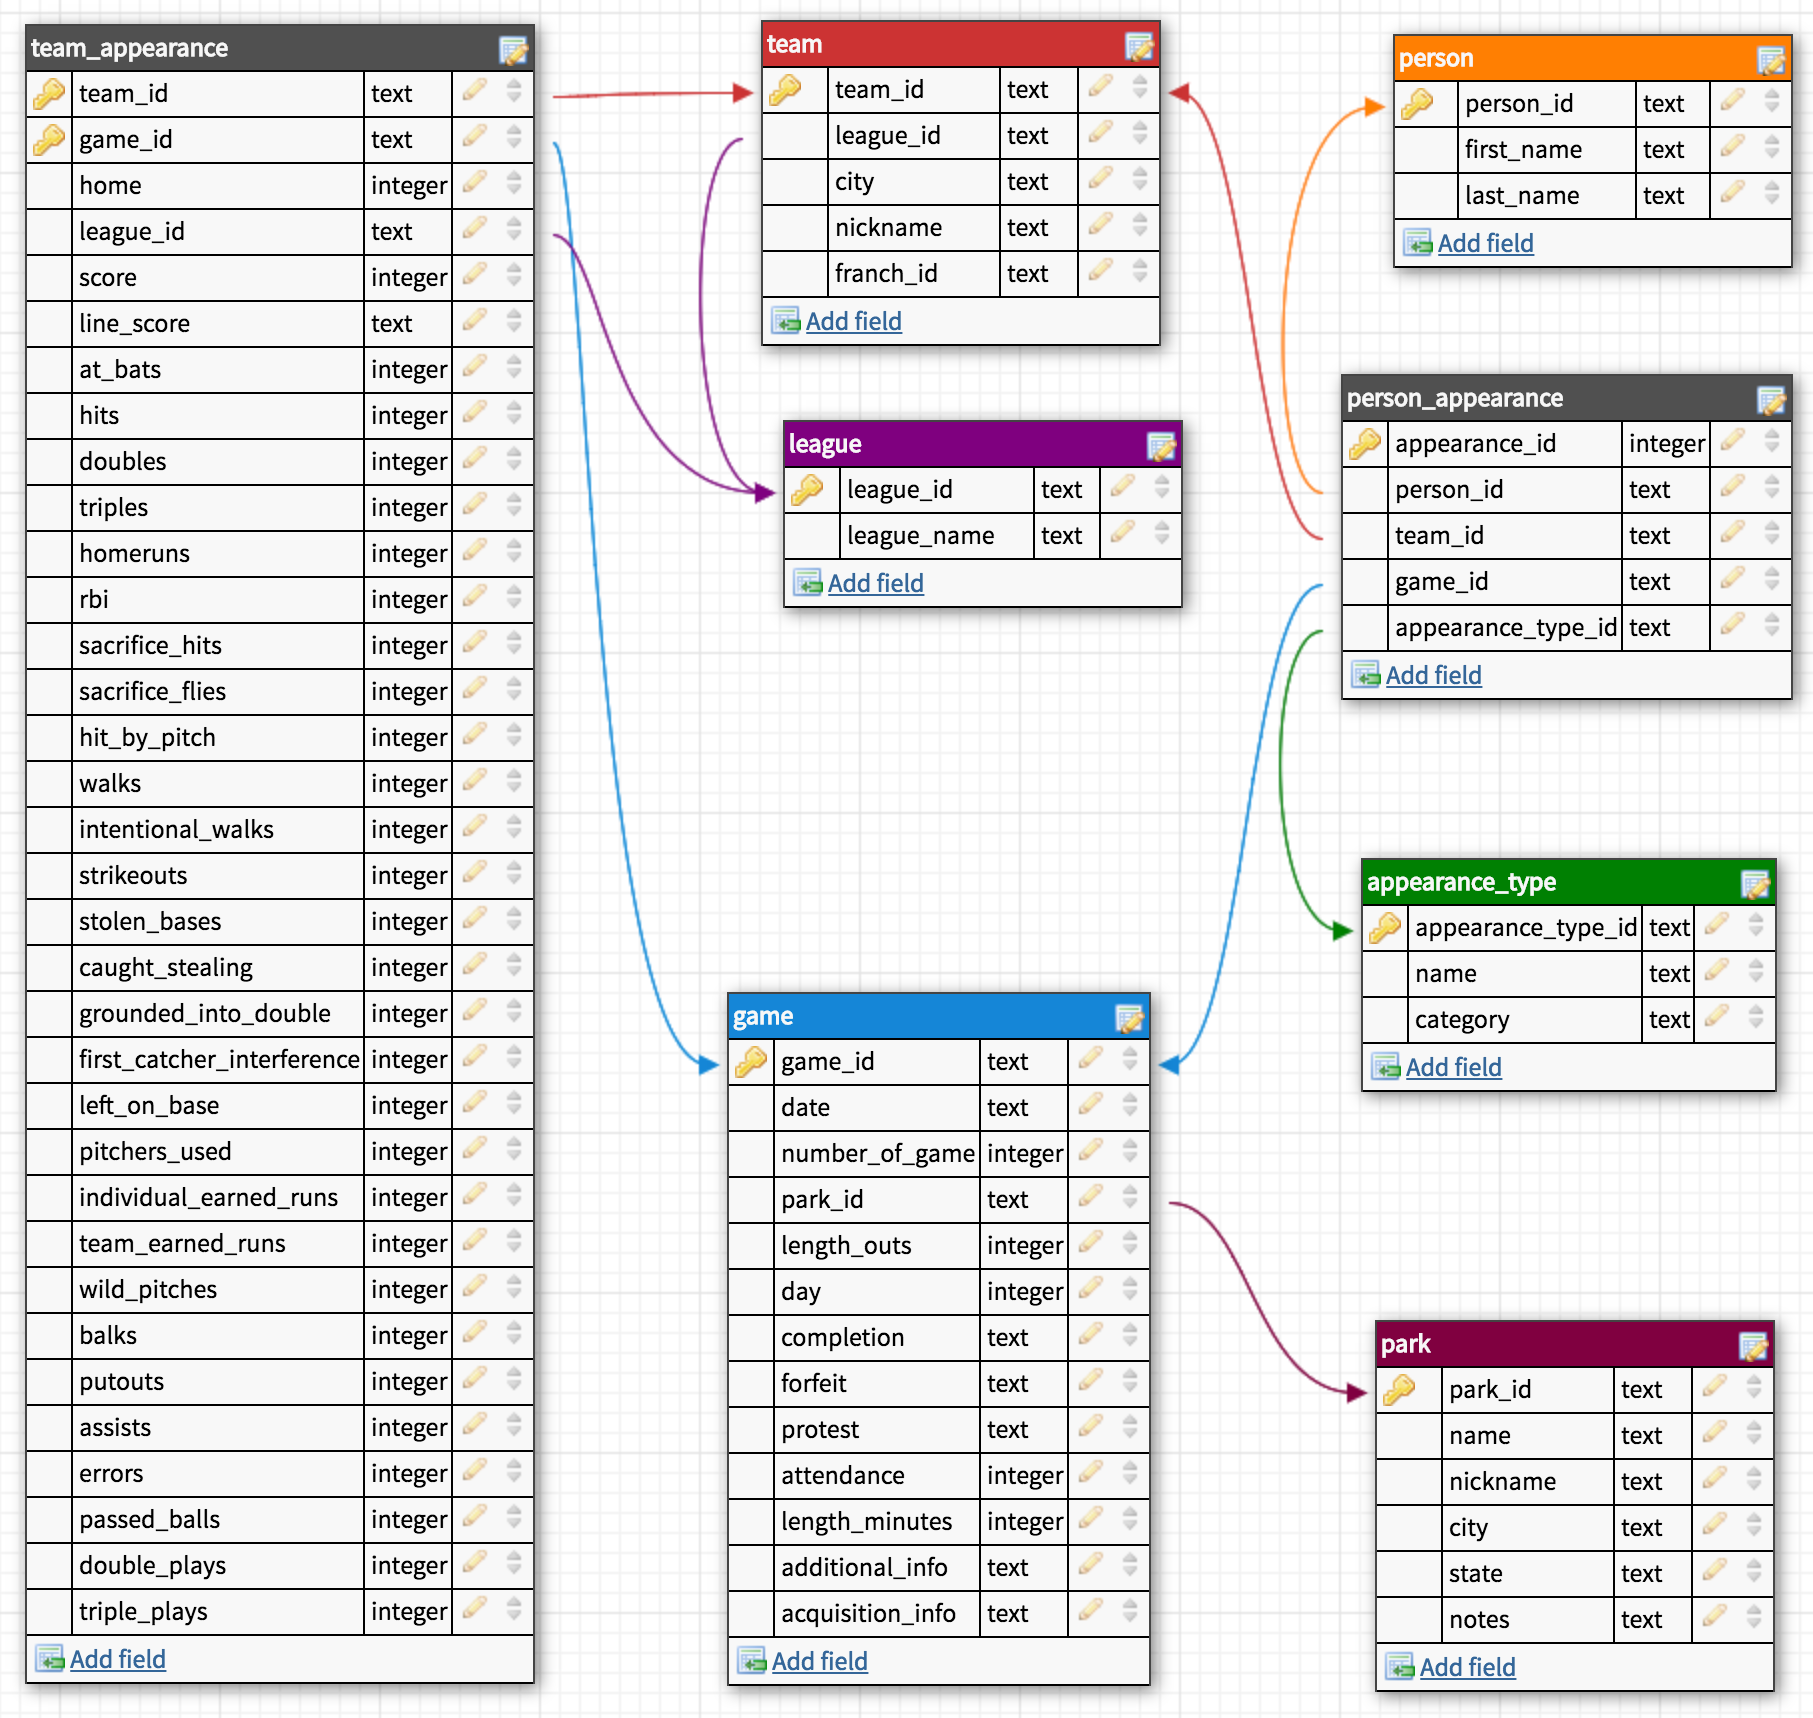

In [26]:
from IPython.display import Image
Image("schema.png")

As we work through creating the tables in this schema, we'll talk about why we made particular choices during the normalization process. 

The tables we will create are below, with some notes on the normalization choices made:

 - `person`
   - Each of the 'debut' columns have been omitted, as the data will be able to be found from other tables.
   - Since the game log file has no data on coaches, we made the decision to not include this data.
   
 - `park`
   - The `start`, `end`, and `league` columns contain data that is found in the main `game` log and can be removed.
   
   
 - `league`
   - Because some of the older leagues are not well known, we will create a table to store league names.
   
- `appearance_type`
   - Our appearance table will include data on players with positions, umpires, managers, and awards (like winning pitcher). This table will store information on what different types of appearances are available.



## Creating Tables Without Foreign Keys

We'll start by creating the tables that don't contain any foreign key relations. It's important to start with these tables, as other tables will have relations to these tables, and so these tables will need to exist first.

In [27]:
c1 = """
CREATE TABLE IF NOT EXISTS person (
    person_id TEXT PRIMARY KEY,
    first_name TEXT,
    last_name TEXT
);
"""

c2 = """
INSERT OR IGNORE INTO person
SELECT
    id,
    first,
    last
FROM person_codes;
"""

q = """
SELECT * FROM person
LIMIT 5;
"""

run_command(c1)
run_command(c2)
run_query(q)

,person_id,first_name,last_name
0,aardd001,David,Aardsma
1,aaroh101,Hank,Aaron
2,aarot101,Tommie,Aaron
3,aased001,Don,Aase
4,abada001,Andy,Abad


In [28]:
c1 = """
CREATE TABLE IF NOT EXISTS park (
    park_id TEXT PRIMARY KEY,
    name TEXT,
    nickname TEXT,
    city TEXT,
    state TEXT,
    notes TEXT
);
"""

c2 = """
INSERT OR IGNORE INTO park
SELECT
    park_id,
    name,
    aka,
    city,
    state,
    notes
FROM park_codes;
"""

q = """
SELECT * FROM park
LIMIT 5;
"""

run_command(c1)
run_command(c2)
run_query(q)

,park_id,name,nickname,city,state,notes
0,ALB01,Riverside Park,None,Albany,NY,TRN:9/11/80;6/15&9/10/1881;5/16-5/18&5/30/1882
1,ALT01,Columbia Park,None,Altoona,PA,None
2,ANA01,Angel Stadium of Anaheim,Edison Field; Anaheim Stadium,Anaheim,CA,None
3,ARL01,Arlington Stadium,None,Arlington,TX,None
4,ARL02,Rangers Ballpark in Arlington,The Ballpark in Arlington; Ameriquest Fl,Arlington,TX,None


In [29]:
c1 = """
CREATE TABLE IF NOT EXISTS league (
    league_id TEXT PRIMARY KEY,
    name TEXT
);
"""

c2 = """
INSERT OR IGNORE INTO league
VALUES
    ("NL", "National League"),
    ("AL", "American League"),
    ("AA", "American Association"),
    ("FL", "Federal League"),
    ("PL", "Players League"),
    ("UA", "Union Association")
;
"""

q = """
SELECT * FROM league
"""

run_command(c1)
run_command(c2)
run_query(q)

,league_id,name
0,NL,National League
1,AL,American League
2,AA,American Association
3,FL,Federal League
4,PL,Players League
5,UA,Union Association


In [30]:
c1 = "DROP TABLE IF EXISTS appearance_type;"

run_command(c1)

c2 = """
CREATE TABLE appearance_type (
    appearance_type_id TEXT PRIMARY KEY,
    name TEXT,
    category TEXT
);
"""
run_command(c2)

appearance_type = pd.read_csv('appearance_type.csv')

with sqlite3.connect('mlb.db') as conn:
    appearance_type.to_sql('appearance_type',
                           conn,
                           index=False,
                           if_exists='append')

q = """
SELECT * FROM appearance_type;
"""

run_query(q)

,appearance_type_id,name,category
0,O1,Batter 1,offense
1,O2,Batter 2,offense
2,O3,Batter 3,offense
3,O4,Batter 4,offense
4,O5,Batter 5,offense
5,O6,Batter 6,offense
6,O7,Batter 7,offense
7,O8,Batter 8,offense
8,O9,Batter 9,offense
9,D1,Pitcher,defense


## Adding The Team and Game Tables

Now that we have added all of the tables that don't have foreign key relationships, lets add the next two tables. The game and team tables need to exist before our two appearance tables are created. Here are the schema of these tables, and the two tables they have foreign key relations to:

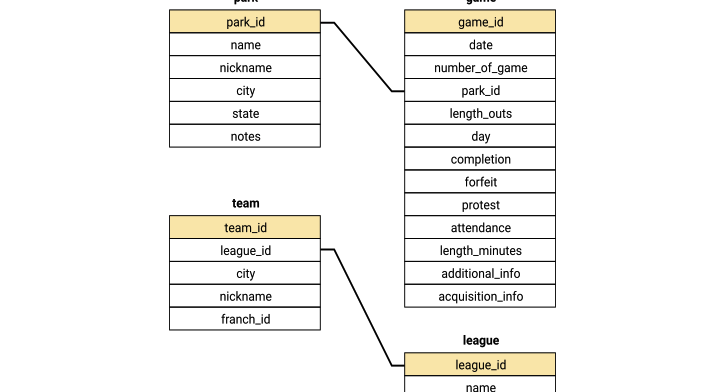

In [33]:
Image("mlb_schema_2.png")

Here are some notes on the normalization choices made with each of these tables:

 - `team`
   - The `start`, `end`, and `sequence` columns can be derived from the game level data.

- `game`
  - We have chosen to include all columns for the game log that don't refer to one specific team or player, instead putting those in two appearance tables.
  - We have removed the column with the day of the week, as this can be derived from the date.
  - We have changed the `day_night` column to day, with the intention of making this a boolean column. Even though SQLite doesn't support the BOOLEAN type, we can use this when creating our table and SQLite will manage the underlying types behind the scenes.

In [31]:
c1 = """
CREATE TABLE IF NOT EXISTS team (
    team_id TEXT PRIMARY KEY,
    league_id TEXT,
    city TEXT,
    nickname TEXT,
    franch_id TEXT,
    FOREIGN KEY (league_id) REFERENCES league(league_id)
);
"""

c2 = """
INSERT OR IGNORE INTO team
SELECT
    team_id,
    league,
    city,
    nickname,
    franch_id
FROM team_codes;
"""

q = """
SELECT * FROM team
LIMIT 5;
"""

run_command(c1)
run_command(c2)
run_query(q)

,team_id,league_id,city,nickname,franch_id
0,ALT,UA,Altoona,Mountain Cities,ALT
1,ARI,NL,Arizona,Diamondbacks,ARI
2,BFN,NL,Buffalo,Bisons,BFN
3,BFP,PL,Buffalo,Bisons,BFP
4,BL1,None,Baltimore,Canaries,BL1


In [34]:
c1 = """
CREATE TABLE IF NOT EXISTS game (
    game_id TEXT PRIMARY KEY,
    date TEXT,
    number_of_game INTEGER,
    park_id TEXT,
    length_outs INTEGER,
    day BOOLEAN,
    completion TEXT,
    forefeit TEXT,
    protest TEXT,
    attendance INTEGER,
    legnth_minutes INTEGER,
    additional_info TEXT,
    acquisition_info TEXT,
    FOREIGN KEY (park_id) REFERENCES park(park_id)
);
"""

c2 = """
INSERT OR IGNORE INTO game
SELECT
    game_id,
    date,
    number_of_game,
    park_id,
    length_outs,
    CASE
        WHEN day_night = "D" THEN 1
        WHEN day_night = "N" THEN 0
        ELSE NULL
        END
        AS day,
    completion,
    forefeit,
    protest,
    attendance,
    length_minutes,
    additional_info,
    acquisition_info
FROM game_log;
"""

q = """
SELECT * FROM game
LIMIT 5;
"""

run_command(c1)
run_command(c2)
run_query(q)

,game_id,date,number_of_game,park_id,length_outs,day,completion,forefeit,protest,attendance,legnth_minutes,additional_info,acquisition_info
0,18710504FW10,18710504,0,FOR01,54,1,None,None,None,200,120,None,Y
1,18710505WS30,18710505,0,WAS01,54,1,None,None,None,5000,145,HTBF,Y
2,18710506RC10,18710506,0,RCK01,54,1,None,None,None,1000,140,None,Y
3,18710508CH10,18710508,0,CHI01,54,1,None,None,None,5000,150,None,Y
4,18710509TRO0,18710509,0,TRO01,54,1,None,None,None,3250,145,HTBF,Y


## Adding the Team Appearance Table

At this point, because we have told SQLite to enforce foreign key constraints and have inserted data that obeys these contraints, we'll get an error if we try to drop a table or delete rows within a table. For example, you might try running `DELETE FROM park where park_id = "FOR01"`;. If we get stuck, one option is to run `!rm mlb.db` in its own Jupyter cell to delete the database file so qw can run all the cells to recreate the database files, tables and data.

Our next task is to add the `team_appearance` table. 

Steps:

 - Create the `team_appearance` table with columns, primary key, and foreign keys as shown in the schema diagram.
 - Select the appropriate type based on the data.
 - Insert the data from the `game_log` table, using a `UNION` clause to combine the data from the column sets for the home and away teams.


Here is the schema of the table and the three tables it has foreign key relations to:

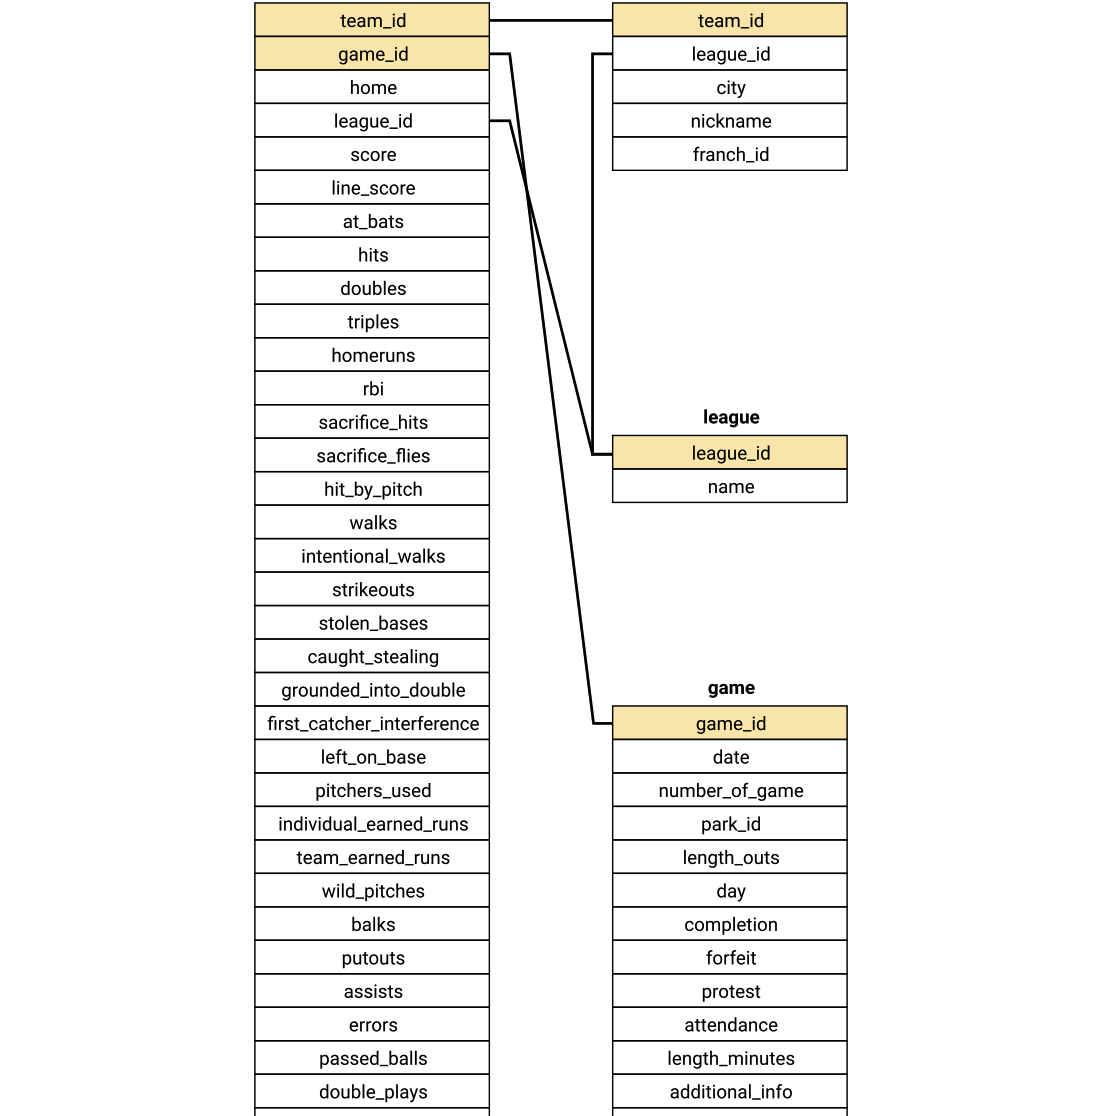

In [35]:
Image("mlb_schema_3.png")

In [36]:
c1 = """
CREATE TABLE IF NOT EXISTS team_appearance (
    team_id TEXT,
    game_id TEXT,
    home BOOLEAN,
    league_id TEXT,
    score INTEGER,
    line_score TEXT,
    at_bats INTEGER,
    hits INTEGER,
    doubles INTEGER,
    triples INTEGER,
    homeruns INTEGER,
    rbi INTEGER,
    sacrifice_hits INTEGER,
    sacrifice_flies INTEGER,
    hit_by_pitch INTEGER,
    walks INTEGER,
    intentional_walks INTEGER,
    strikeouts INTEGER,
    stolen_bases INTEGER,
    caught_stealing INTEGER,
    grounded_into_double INTEGER,
    first_catcher_interference INTEGER,
    left_on_base INTEGER,
    pitchers_used INTEGER,
    individual_earned_runs INTEGER,
    team_earned_runs INTEGER,
    wild_pitches INTEGER,
    balks INTEGER,
    putouts INTEGER,
    assists INTEGER,
    errors INTEGER,
    passed_balls INTEGER,
    double_plays INTEGER,
    triple_plays INTEGER,
    PRIMARY KEY (team_id, game_id),
    FOREIGN KEY (team_id) REFERENCES team(team_id),
    FOREIGN KEY (game_id) REFERENCES game(game_id),
    FOREIGN KEY (team_id) REFERENCES team(team_id)
);
"""

run_command(c1)

c2 = """
INSERT OR IGNORE INTO team_appearance
    SELECT
        h_name,
        game_id,
        1 AS home,
        h_league,
        h_score,
        h_line_score,
        h_at_bats,
        h_hits,
        h_doubles,
        h_triples,
        h_homeruns,
        h_rbi,
        h_sacrifice_hits,
        h_sacrifice_flies,
        h_hit_by_pitch,
        h_walks,
        h_intentional_walks,
        h_strikeouts,
        h_stolen_bases,
        h_caught_stealing,
        h_grounded_into_double,
        h_first_catcher_interference,
        h_left_on_base,
        h_pitchers_used,
        h_individual_earned_runs,
        h_team_earned_runs,
        h_wild_pitches,
        h_balks,
        h_putouts,
        h_assists,
        h_errors,
        h_passed_balls,
        h_double_plays,
        h_triple_plays
    FROM game_log

UNION

    SELECT    
        v_name,
        game_id,
        0 AS home,
        v_league,
        v_score,
        v_line_score,
        v_at_bats,
        v_hits,
        v_doubles,
        v_triples,
        v_homeruns,
        v_rbi,
        v_sacrifice_hits,
        v_sacrifice_flies,
        v_hit_by_pitch,
        v_walks,
        v_intentional_walks,
        v_strikeouts,
        v_stolen_bases,
        v_caught_stealing,
        v_grounded_into_double,
        v_first_catcher_interference,
        v_left_on_base,
        v_pitchers_used,
        v_individual_earned_runs,
        v_team_earned_runs,
        v_wild_pitches,
        v_balks,
        v_putouts,
        v_assists,
        v_errors,
        v_passed_balls,
        v_double_plays,
        v_triple_plays
    from game_log;
"""

run_command(c2)

q = """
SELECT * FROM team_appearance
WHERE game_id = (
                 SELECT MIN(game_id) from game
                )
   OR game_id = (
                 SELECT MAX(game_id) from game
                )
ORDER By game_id, home;
"""

run_query(q)

,team_id,game_id,home,league_id,score,line_score,at_bats,hits,doubles,triples,homeruns,rbi,sacrifice_hits,sacrifice_flies,hit_by_pitch,walks,intentional_walks,strikeouts,stolen_bases,caught_stealing,grounded_into_double,first_catcher_interference,left_on_base,pitchers_used,individual_earned_runs,team_earned_runs,wild_pitches,balks,putouts,assists,errors,passed_balls,double_plays,triple_plays
0,CL1,18710504FW10,0,None,0,000000000,30,4,1,0,0,0,0,0,0,1,NaN,6,1,NaN,-1,NaN,4,1,1,1,0,0,27,9,0,3,0,0
1,FW1,18710504FW10,1,None,2,010010000,31,4,1,0,0,2,0,0,0,1,NaN,0,0,NaN,-1,NaN,3,1,0,0,0,0,27,3,3,1,1,0
2,MIA,20161002WAS0,0,NL,7,000230020,38,14,1,1,2,7,1,0,0,3,2.0,10,1,1.0,1,0.0,8,7,10,10,1,0,24,11,0,0,1,0
3,WAS,20161002WAS0,1,NL,10,03023002x,30,10,2,0,1,10,1,1,1,8,0.0,3,2,0.0,1,0.0,7,6,7,7,1,0,27,11,0,0,1,0


## Adding the Person Appearance Table

The final table we need to create is `person_appearance`. 

The `person_appearance` table will be used to store information on appearances in games by managers, players, and umpires as detailed in the `appearance_type` table.

We'll need to use a similar technique to insert data as we used with the `team_appearance` table, however we will have to write much larger queries - one for each column instead of one for each team as before. We will need to work out for each column what the `appearance_type_id` will be by cross-referencing the columns with the `appearance_type` table.

We have decided to create an integer primary key for this table, because having every column be a compound primary quickly becomes cumbersome when writing queries. In SQLite, if you have an integer primary key and don't specify a value for this column when inserting rows, SQLite will autoincrement this column for you.

Steps:

 - Create the `person_appearance` table with columns, primary key, and foreign keys as shown in the schema diagram.
 - Select the appropriate type based on the data.
 - Insert the data from the `game_log` table, using `UNION` clauses to combine the data from the columns for managers, umpires, pitchers, and awards.
 - Use a loop with string formatting to insert the data for offensive and defensive positions from the game_log table.

Here is the schema of the table and the four tables it has foreign key relations to:

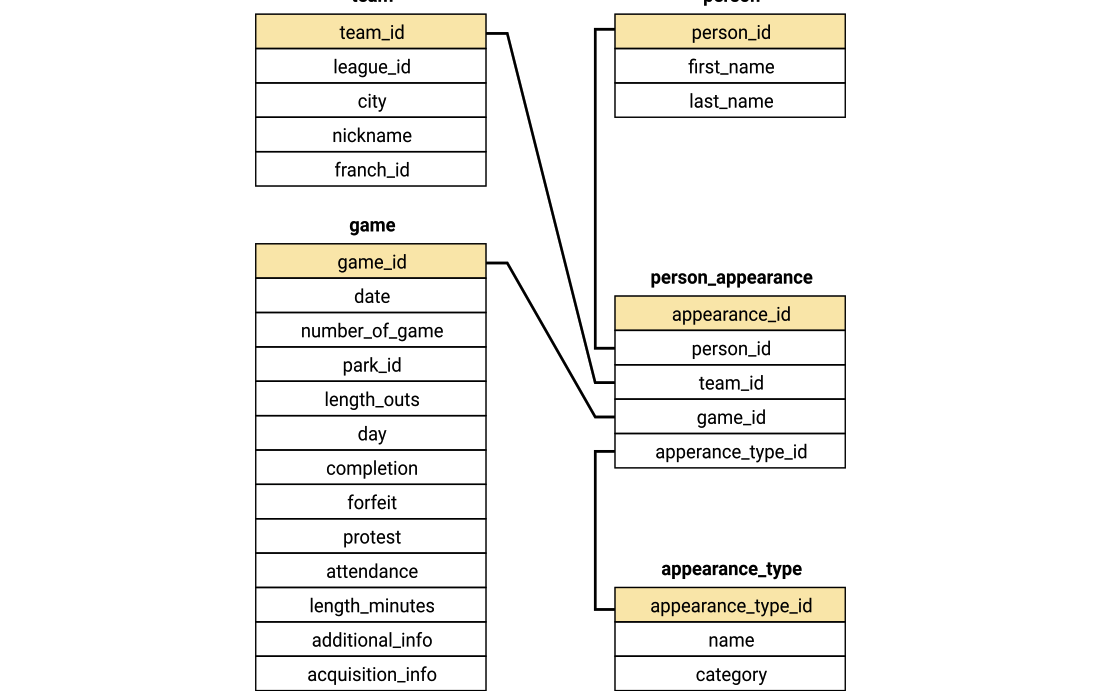

In [37]:
Image("mlb_schema_4.png")

In [38]:
c0 = "DROP TABLE IF EXISTS person_appearance"

run_command(c0)

c1 = """
CREATE TABLE person_appearance (
    appearance_id INTEGER PRIMARY KEY,
    person_id TEXT,
    team_id TEXT,
    game_id TEXT,
    appearance_type_id,
    FOREIGN KEY (person_id) REFERENCES person(person_id),
    FOREIGN KEY (team_id) REFERENCES team(team_id),
    FOREIGN KEY (game_id) REFERENCES game(game_id),
    FOREIGN KEY (appearance_type_id) REFERENCES appearance_type(appearance_type_id)
);
"""

c2 = """
INSERT OR IGNORE INTO person_appearance (
    game_id,
    team_id,
    person_id,
    appearance_type_id
) 
    SELECT
        game_id,
        NULL,
        hp_umpire_id,
        "UHP"
    FROM game_log
    WHERE hp_umpire_id IS NOT NULL    

UNION

    SELECT
        game_id,
        NULL,
        [1b_umpire_id],
        "U1B"
    FROM game_log
    WHERE "1b_umpire_id" IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        [2b_umpire_id],
        "U2B"
    FROM game_log
    WHERE [2b_umpire_id] IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        [3b_umpire_id],
        "U3B"
    FROM game_log
    WHERE [3b_umpire_id] IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        lf_umpire_id,
        "ULF"
    FROM game_log
    WHERE lf_umpire_id IS NOT NULL

UNION

    SELECT
        game_id,
        NULL,
        rf_umpire_id,
        "URF"
    FROM game_log
    WHERE rf_umpire_id IS NOT NULL

UNION

    SELECT
        game_id,
        v_name,
        v_manager_id,
        "MM"
    FROM game_log
    WHERE v_manager_id IS NOT NULL

UNION

    SELECT
        game_id,
        h_name,
        h_manager_id,
        "MM"
    FROM game_log
    WHERE h_manager_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        winning_pitcher_id,
        "AWP"
    FROM game_log
    WHERE winning_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score < v_score THEN h_name
            ELSE v_name
            END,
        losing_pitcher_id,
        "ALP"
    FROM game_log
    WHERE losing_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        saving_pitcher_id,
        "ASP"
    FROM game_log
    WHERE saving_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        CASE
            WHEN h_score > v_score THEN h_name
            ELSE v_name
            END,
        winning_rbi_batter_id,
        "AWB"
    FROM game_log
    WHERE winning_rbi_batter_id IS NOT NULL

UNION

    SELECT
        game_id,
        v_name,
        v_starting_pitcher_id,
        "PSP"
    FROM game_log
    WHERE v_starting_pitcher_id IS NOT NULL

UNION

    SELECT
        game_id,
        h_name,
        h_starting_pitcher_id,
        "PSP"
    FROM game_log
    WHERE h_starting_pitcher_id IS NOT NULL;
"""

template = """
INSERT INTO person_appearance (
    game_id,
    team_id,
    person_id,
    appearance_type_id
) 
    SELECT
        game_id,
        {hv}_name,
        {hv}_player_{num}_id,
        "O{num}"
    FROM game_log
    WHERE {hv}_player_{num}_id IS NOT NULL

UNION

    SELECT
        game_id,
        {hv}_name,
        {hv}_player_{num}_id,
        "D" || CAST({hv}_player_{num}_def_pos AS INT)
    FROM game_log
    WHERE {hv}_player_{num}_id IS NOT NULL;
"""

run_command(c1)
run_command(c2)

for hv in ["h","v"]:
    for num in range(1,10):
        query_vars = {
            "hv": hv,
            "num": num
        }
        run_command(template.format(**query_vars))

## Confirmation

We'll now confirm that our database is correct:

In [39]:
print(run_query("SELECT COUNT(DISTINCT game_id) games_game FROM game"))
print(run_query("SELECT COUNT(DISTINCT game_id) games_person_appearance FROM person_appearance"))

q = """
SELECT
    pa.*,
    at.name,
    at.category
FROM person_appearance pa
INNER JOIN appearance_type at on at.appearance_type_id = pa.appearance_type_id
WHERE PA.game_id = (
                   SELECT max(game_id)
                    FROM person_appearance
                   )
ORDER BY team_id, appearance_type_id
"""

run_query(q)

   games_game
0      171907
   games_person_appearance
0                   171907


,appearance_id,person_id,team_id,game_id,appearance_type_id,name,category
0,1646109,porta901,None,20161002WAS0,U1B,First Base,umpire
1,1646108,onorb901,None,20161002WAS0,U2B,Second Base,umpire
2,1646107,kellj901,None,20161002WAS0,U3B,Third Base,umpire
3,1646110,tumpj901,None,20161002WAS0,UHP,Home Plate,umpire
4,1646111,brica001,MIA,20161002WAS0,ALP,Losing Pitcher,award
5,6716279,koeht001,MIA,20161002WAS0,D1,Pitcher,defense
6,4744553,telit001,MIA,20161002WAS0,D2,Catcher,defense
7,5589581,bourj002,MIA,20161002WAS0,D3,1st Base,defense
8,4462877,gordd002,MIA,20161002WAS0,D4,2nd Base,defense
9,5026229,pradm001,MIA,20161002WAS0,D5,3rd Base,defense


## Removing the Original Tables

We've now created all normalized tables and inserted all of our data, our last task is to remove the tables we created to import the original CSVs.

Steps:

Drop the tables we created to hold our unnormalized data:
 - `game_log`.
 - `park_codes`.
 - `team_codes`.
 - `person_codes`.

In [40]:
show_tables()


,name,type
0,game_log,table
1,person_codes,table
2,team_codes,table
3,park_codes,table
4,person,table
5,park,table
6,league,table
7,appearance_type,table
8,team,table
9,game,table


In [41]:
tables = [
    "game_log",
    "park_codes",
    "team_codes",
    "person_codes"
]

for t in tables:
    c = '''
    DROP TABLE {}
    '''.format(t)
    
    run_command(c)

show_tables()

,name,type
0,person,table
1,park,table
2,league,table
3,appearance_type,table
4,team,table
5,game,table
6,team_appearance,table
7,person_appearance,table


### Future Steps

 - Transform the the dates into a SQLite compatible format.
 
 - Extract the line scores into innings level data in a new table.
 
 - Create views to make querying stats easier, eg:
   - Season level stats.
   - All time records.
   
 - Supplement the database using new data, for instance:
   - Add data from retrosheet game logs for years after 2016.
   - Source and add missing pitcher information.
   - Add player level per-game stats.
   - Source and include base coach data.